In [ ]:
import os
import base64
import io
from PIL import Image
from IPython.display import display, HTML
import ffmpeg
import speech_recognition as sr
import yt_dlp
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.llms import Ollama
from langchain.schema import Document
from langchain.prompts import PromptTemplate

In [ ]:
os.makedirs('downloaded_video', exist_ok=True)
os.makedirs('frames', exist_ok=True)
os.makedirs('audio', exist_ok=True)
os.makedirs('audio_text', exist_ok=True)

In [ ]:
def download_video(youtube_url, output_path):
    ydl_opts = {
        'outtmpl': output_path,
        'format': 'bestvideo+bestaudio/best',
        'merge_output_format': 'mp4'
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])

In [ ]:
def extract_frames(video_path, output_folder):
    try:
        ffmpeg.input(video_path).output(f'{output_folder}/frame_%04d.png', vf='fps=1/4').run()
    except Exception as e:
        print(f"Error extracting frames: {e}")

In [ ]:
def extract_audio(video_path, output_audio_path):
    try:
        ffmpeg.input(video_path).output(output_audio_path).run()
    except Exception as e:
        print(f"Error extracting audio: {e}")

In [ ]:
def audio_to_text(audio_path, output_text_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_path) as source:
        audio = recognizer.record(source)
    transcription = recognizer.recognize_google(audio)
    with open(output_text_path, 'w') as f:
        f.write(transcription)

In [ ]:
llm = Ollama(model="llava")
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [ ]:
local_storage_path = 'local_chroma_db'
os.makedirs(local_storage_path, exist_ok=True)
chroma_db = Chroma(persist_directory=local_storage_path, embedding_function=embedding_model)


In [ ]:
def generate_frame_summary(frame_path):
    try:
        image = Image.open(frame_path)
        with io.BytesIO() as buffer:
            image.save(buffer, format="PNG")
            image_data = buffer.getvalue()
        encoded_image = base64.b64encode(image_data).decode('utf-8')
        prompt = "Describe the content of the following image in the context of programming or related concepts."
        response = llm.generate(prompts=[prompt], images=[encoded_image])
        return response.generations[0][0].text.strip()
    except Exception as e:
        print(f"Error generating frame summary: {e}")
        return "Error generating frame summary."


In [ ]:
def generate_audio_summary(text):
    try:
        prompt = f"Summarize the following text, focusing on programming concepts: {text}"
        response = llm.generate(prompts=[prompt])
        return response.generations[0][0].text.strip()
    except Exception as e:
        print(f"Error generating audio summary: {e}")
        return "Error generating audio summary."

In [ ]:
def process_frames(frame_folder):
    summaries = []
    for filename in os.listdir(frame_folder):
        if filename.endswith(".png"):
            frame_path = os.path.join(frame_folder, filename)
            summary = generate_frame_summary(frame_path)
            summaries.append({"summary": summary, "path": frame_path})
    return summaries

In [ ]:
def process_audio(audio_text_path):
    try:
        with open(audio_text_path, 'r') as file:
            text = file.read()
        return generate_audio_summary(text)
    except Exception as e:
        print(f"Error processing audio text: {e}")
        return "Error processing audio text."

In [ ]:
def display_image_as_base64(image_path):
    try:
        with open(image_path, "rb") as image_file:
            image_data = image_file.read()
        encoded_image = base64.b64encode(image_data).decode('utf-8')
        img_tag = f'<img src="data:image/png;base64,{encoded_image}" alt="Relevant Image" style="max-width: 300px;"/>'
        display(HTML(img_tag))
    except FileNotFoundError:
        print(f"File not found: {image_path}")

In [ ]:
def main():
    query = "Why should we learn C++?"

    youtube_url = 'https://youtube.com/shorts/1Zku-mXDY9g?si=mS9L4Yx0S3PkO_ux'
    video_output_path = 'downloaded_video/downloaded_video.mp4'
    download_video(youtube_url, video_output_path)

    extract_frames(video_output_path, 'frames')
    audio_output_path = 'audio/audio.wav'
    extract_audio(video_output_path, audio_output_path)

    audio_text_path = 'audio_text/audio_transcription.txt'
    audio_to_text(audio_output_path, audio_text_path)

    frame_summaries = process_frames('frames')
    audio_summary = process_audio(audio_text_path)
    
    documents = [Document(page_content=audio_summary, metadata={"id": "audio_summary"})]

    for summary in frame_summaries:
        documents.append(Document(page_content=summary["summary"], metadata={"id": "frame_summary", "path": summary["path"]}))
    
    chroma_db.add_documents(documents)

    results = chroma_db.similarity_search(query)

    relevant_texts = []
    relevant_images = []

    for result in results:
        if result.metadata["id"] == "audio_summary":
            relevant_texts.append(result.page_content)
        elif result.metadata["id"] == "frame_summary":
            relevant_texts.append(result.page_content)
            relevant_images.append(result.metadata["path"])

    combined_summary = " ".join(relevant_texts)
    
    if combined_summary:
        try:
            images_base64 = []
            for image_path in relevant_images:
                with open(image_path, "rb") as img_file:
                    img_base64 = base64.b64encode(img_file.read()).decode('utf-8')
                    images_base64.append(img_base64)
            
            prompt_template = PromptTemplate(
                template="For the query '{query}', summarize the following content related to programming perception:\n\nAudio Summary:\n{audio_summary}\n\nFrame Summaries:\n{frame_summaries}\n\nRelevant Images:\n{images_base64}",
                input_variables=["query", "audio_summary", "frame_summaries", "images_base64"]
            )
            prompt = prompt_template.format(
                query=query,
                audio_summary=combined_summary,
                frame_summaries="\n".join(relevant_texts),
                images_base64=" ".join(images_base64)
            )
            
            response = llm.generate(prompts=[prompt])
            final_summary = response.generations[0][0].text.strip()
        except Exception as e:
            print(f"Error generating final summary: {e}")
            final_summary = "Error generating final summary."
    else:
        final_summary = "No relevant text found."

    print("Final Response from LLAVA:")
    print(final_summary)

    for image_path in relevant_images:
        display_image_as_base64(image_path)


c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Bot

[youtube] Extracting URL: https://youtube.com/shorts/1Zku-mXDY9g?si=mS9L4Yx0S3PkO_ux
[youtube] 1Zku-mXDY9g: Downloading webpage
[youtube] 1Zku-mXDY9g: Downloading ios player API JSON
[youtube] 1Zku-mXDY9g: Downloading web creator player API JSON
[youtube] 1Zku-mXDY9g: Downloading m3u8 information
[info] 1Zku-mXDY9g: Downloading 1 format(s): 303+251
[download] Destination: downloaded_video\downloaded_video.f303.webm
[download] 100% of   12.98MiB in 00:00:23 at 575.52KiB/s 
[download] Destination: downloaded_video\downloaded_video.f251.webm
[download] 100% of  611.30KiB in 00:00:00 at 684.22KiB/s 
[Merger] Merging formats into "downloaded_video\downloaded_video.mp4"
Deleting original file downloaded_video\downloaded_video.f303.webm (pass -k to keep)
Deleting original file downloaded_video\downloaded_video.f251.webm (pass -k to keep)
Final Response from LLAVA:
The image you have provided appears to be a base64 encoded image. Base64 encoding is used to encode binary data into a format that


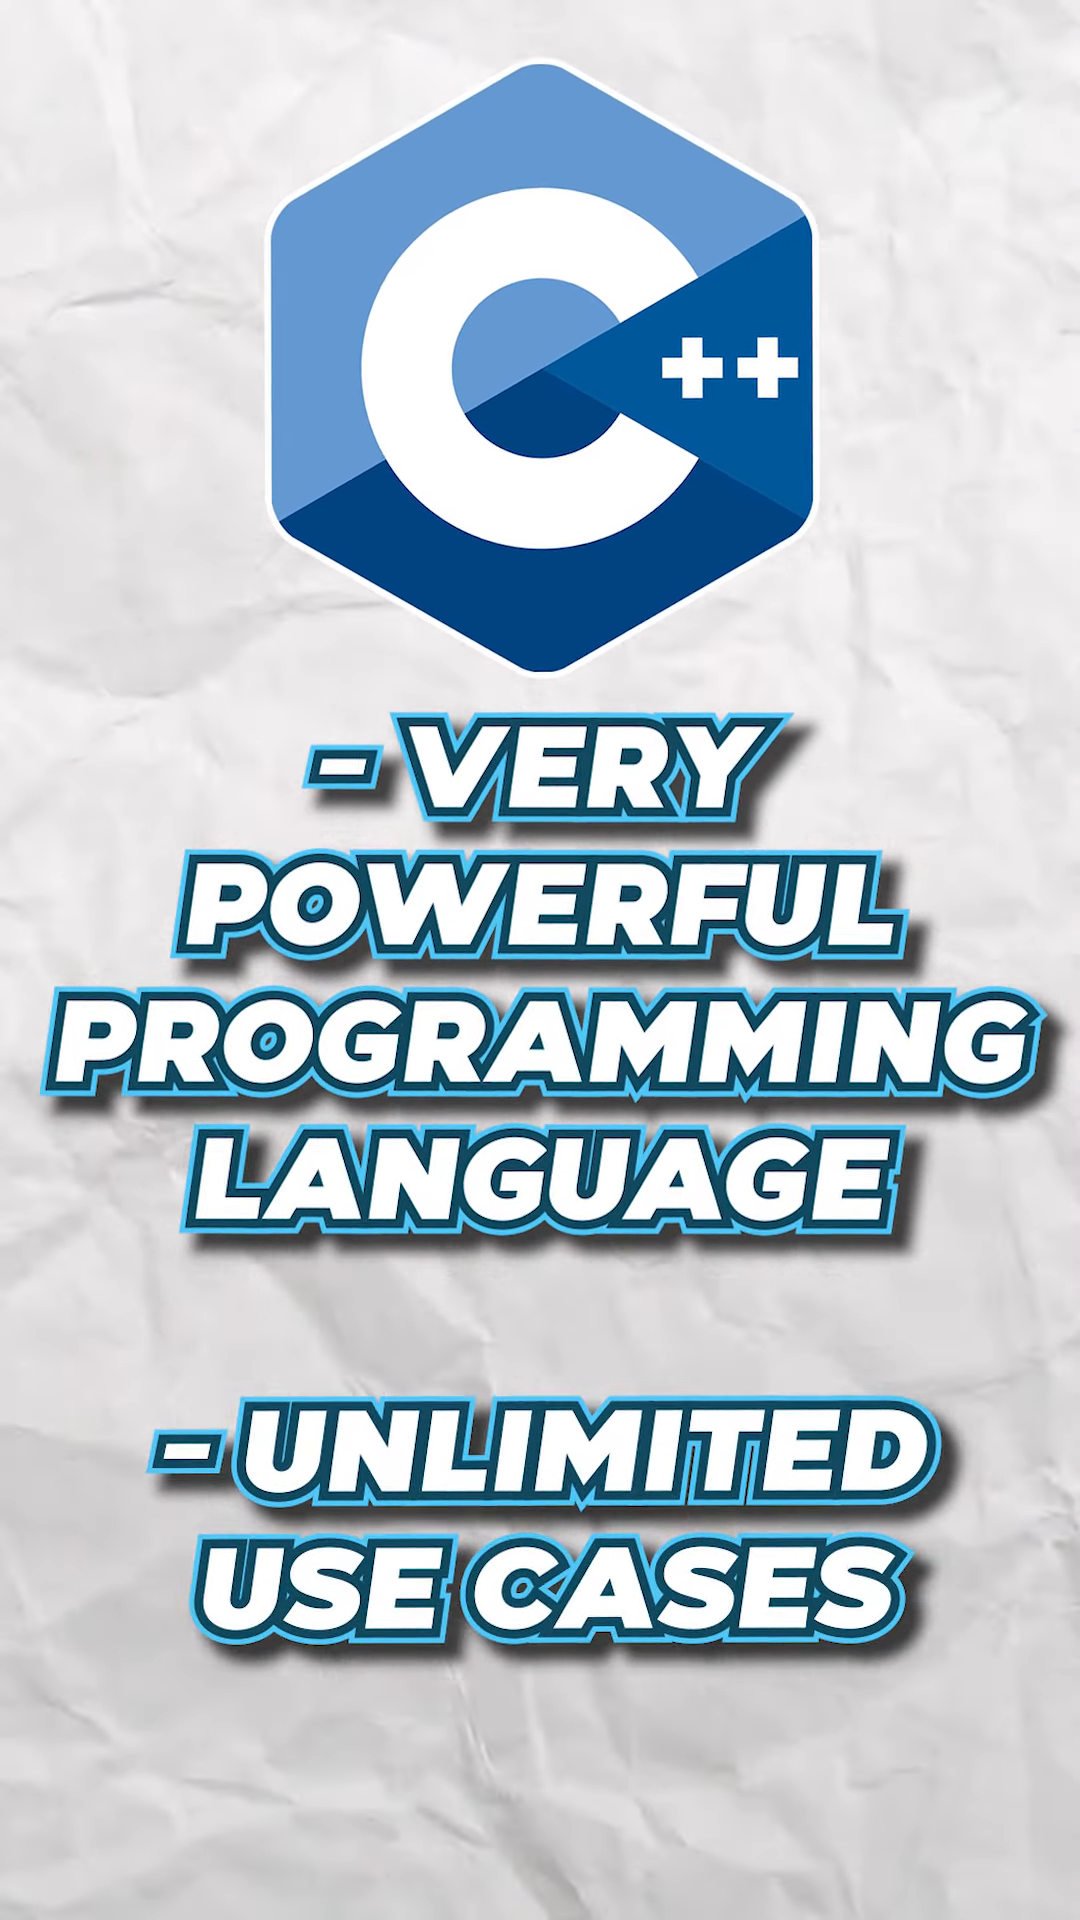


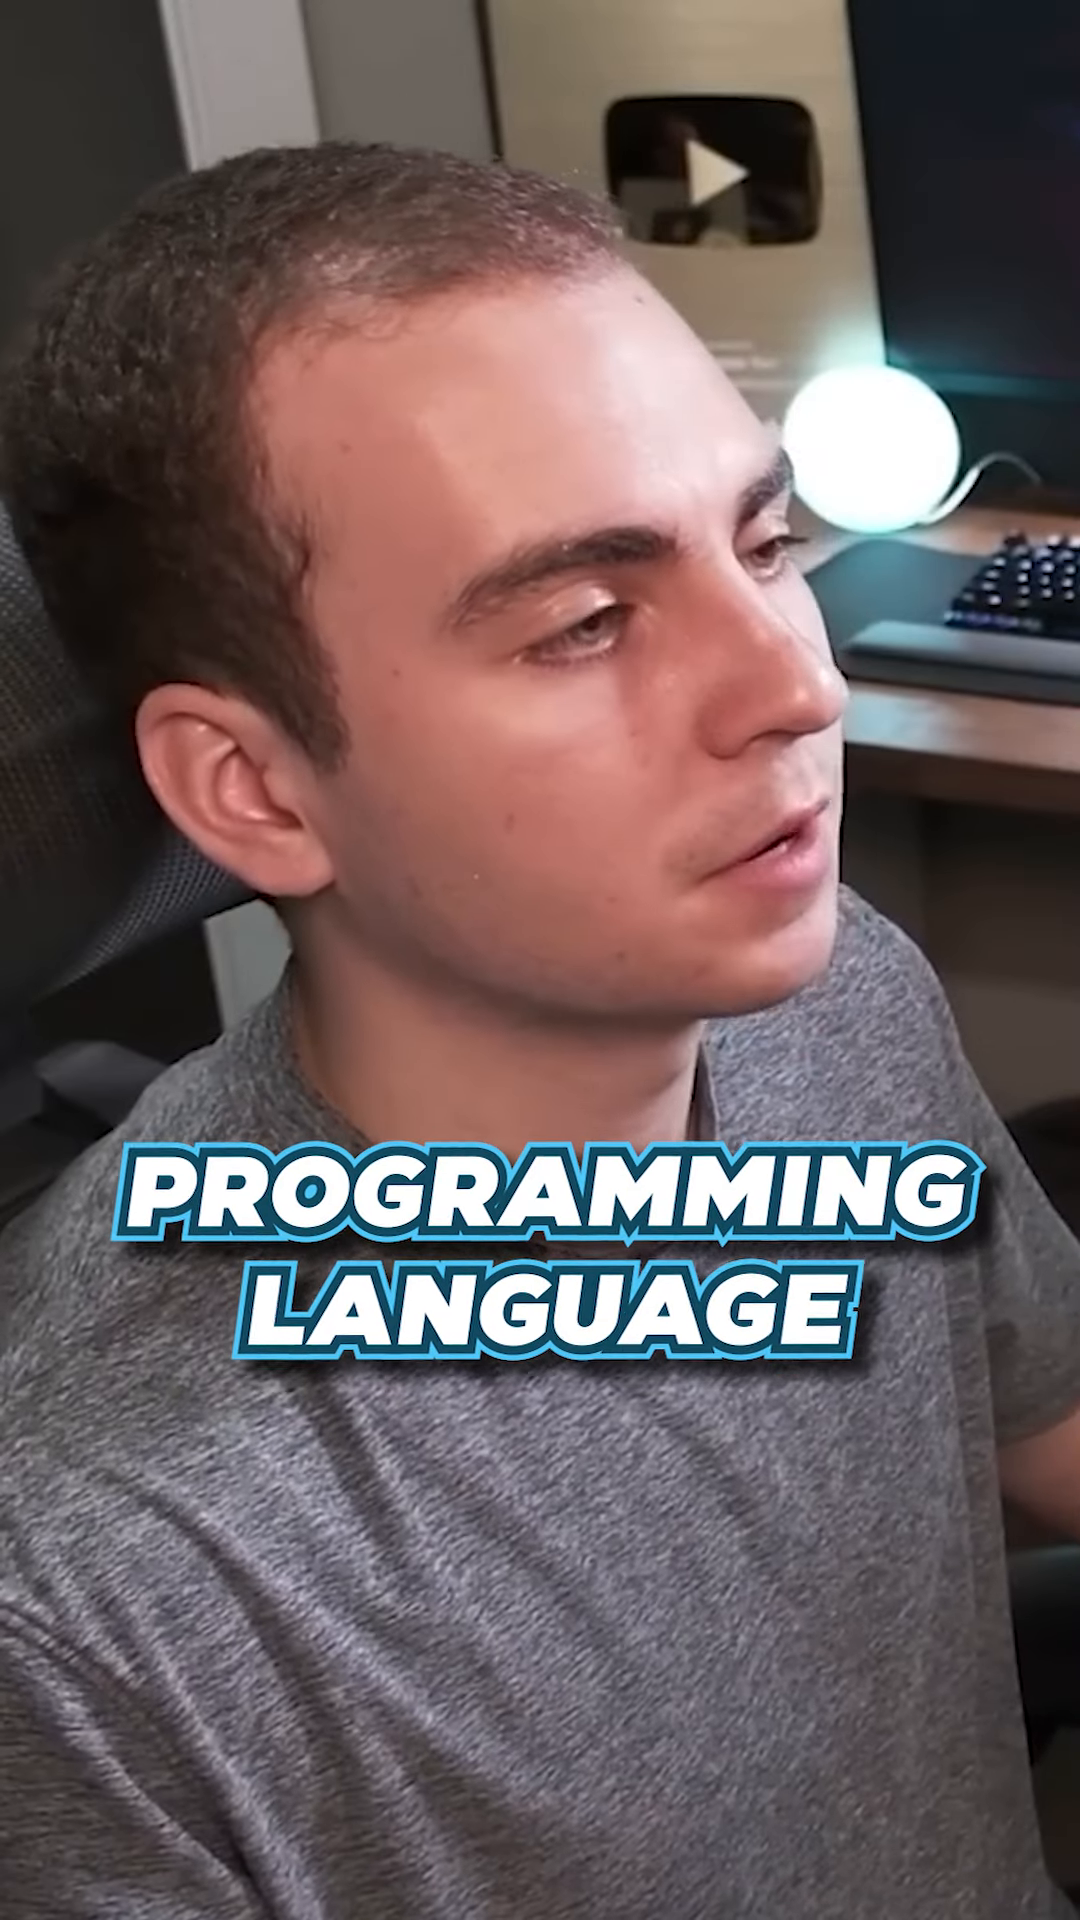


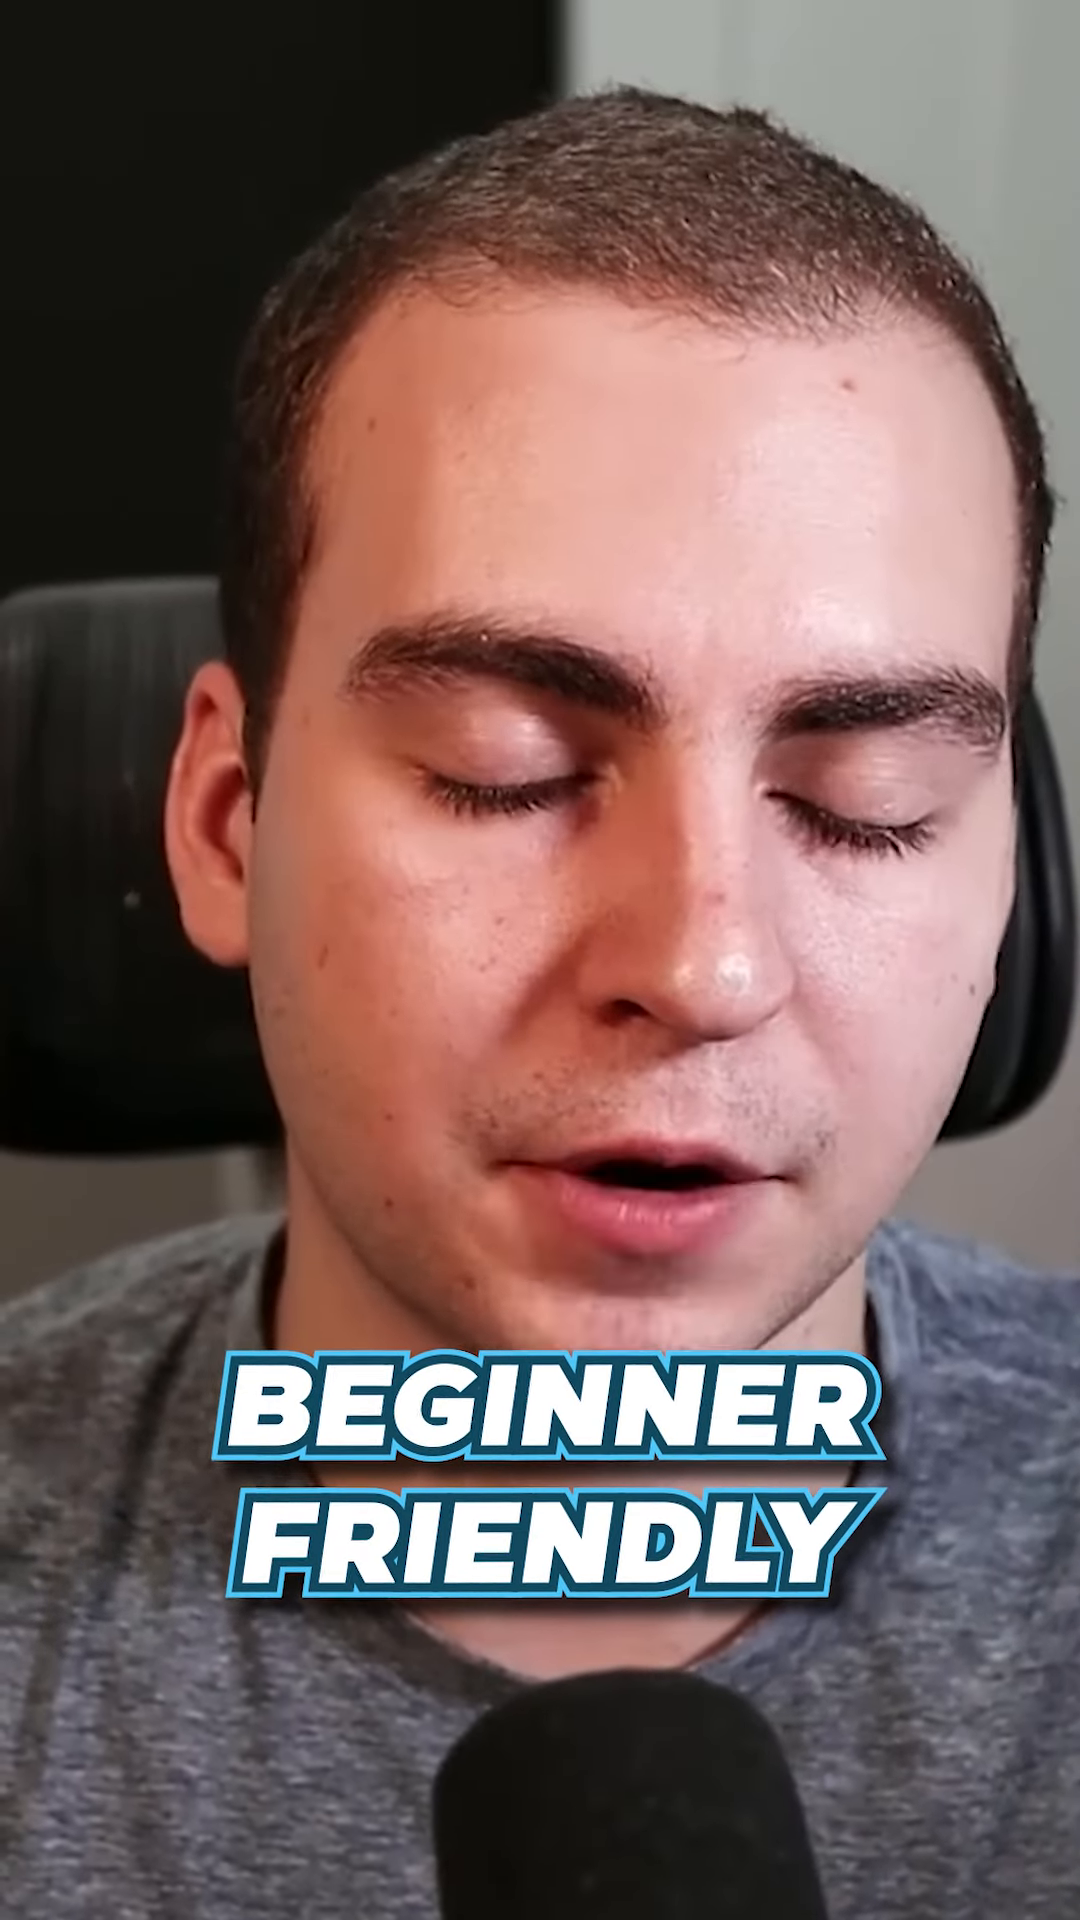

In [1]:

if __name__ == "__main__":
    main()
